In [1]:
import torchvision
import torch
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
class Sqeeze(object):
    def __call__(self, sample):
        sqzd = torch.squeeze(sample)
        return sqzd
    
    def __repr__(self) -> str:
        return 'Squeze()'

transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.1307,), (0.3081)),
    Sqeeze()
])

mnist_train = torchvision.datasets.MNIST(root='./dataset', train=True, download=True, transform=transform)
mnist_test = torchvision.datasets.MNIST(root='./dataset', train=False, download=True, transform=transform)

mnist_train_data = mnist_train.data
mnist_train_labels = mnist_train.targets
mnist_test_data = mnist_test.data
mnist_test_labels = mnist_test.targets



In [3]:
mnist_train_data.numpy().shape

(60000, 28, 28)

In [4]:
from torch.utils.data import TensorDataset

mnist_train_data, mnist_train_labels = torch.tensor(mnist_train_data).to(device), torch.tensor(mnist_train_labels).to(device)
mnist_test_data, mnist_test_labels = torch.tensor(mnist_test_data).to(device), torch.tensor(mnist_test_labels).to(device)

mnist_train_data = torchvision.transforms.Normalize((0.1307,), (0.3081))(mnist_train_data.float())
mnist_test_data = torchvision.transforms.Normalize((0.1307,), (0.3081))(mnist_test_data.float())

mnist_train = TensorDataset(mnist_train_data, mnist_train_labels)
mnist_test = TensorDataset(mnist_test_data, mnist_test_labels)

train_dataloader = torch.utils.data.DataLoader(mnist_train, batch_size=32, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(mnist_test, batch_size=32, shuffle=True)

/home/amar/Desktop/thesis-2022/env/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until
/home/amar/Desktop/thesis-2022/env/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.


In [5]:
for input, label in test_dataloader:
    print(input.shape)
    print(input.dtype)
    print(label.shape)
    print(label.dtype)
    break

torch.Size([32, 28, 28])
torch.float32
torch.Size([32])
torch.int64


In [11]:
import os
from main import init_model_params
from datetime import datetime
from models import GCNAuto

model_name = 'imagine_gcn_auto'
random_seed = 0
dataset_name = 'mnist'
time_now = datetime.now().strftime('%Y-%m-%d-%H-%M')
results_path = os.path.join('output', time_now, model_name, dataset_name, str(random_seed))
os.makedirs(results_path, exist_ok=True)

model = GCNAuto(kernel_type='b', in_features=28, n_nodes=28, num_classes=10, hidden_sizes=[256, 512, 256], dropout_p=0.2, device=device)

dataset_sizes = {'train': len(train_dataloader), 'val': len(test_dataloader), 'test': len(test_dataloader)}
dataloaders = {'train': train_dataloader, 'val': test_dataloader, 'test': test_dataloader}
class_names = None

In [12]:
model = init_model_params(model, random_seed=random_seed)
model.init_adj_diag()
model = model.to(device)

In [14]:
from train import train_model_2

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.9)

model, history = train_model_2(model, optimizer, scheduler, criterion, train_dataloader, test_dataloader, 100, random_seed, device, verbose=True)

train() called: model=GCNAuto, opt=Adam(lr=0.001000), epochs=100, device=cuda

Epoch   1/100, LR: 0.0010, train loss: 0.1423, train acc: 0.9580, val loss: 0.1150, val acc: 0.9647
Epoch  10/100, LR: 0.0010, train loss: 0.1216, train acc: 0.9642, val loss: 0.1367, val acc: 0.9627
Epoch  20/100, LR: 0.0010, train loss: 0.1177, train acc: 0.9647, val loss: 0.1474, val acc: 0.9604
Epoch  30/100, LR: 0.0009, train loss: 0.0968, train acc: 0.9708, val loss: 0.1199, val acc: 0.9674
Epoch  40/100, LR: 0.0009, train loss: 0.1058, train acc: 0.9688, val loss: 0.1412, val acc: 0.9649
Epoch  50/100, LR: 0.0008, train loss: 0.0810, train acc: 0.9756, val loss: 0.1233, val acc: 0.9680
Epoch  60/100, LR: 0.0008, train loss: 0.0786, train acc: 0.9765, val loss: 0.1126, val acc: 0.9690
Epoch  70/100, LR: 0.0007, train loss: 0.0812, train acc: 0.9755, val loss: 0.1086, val acc: 0.9730
Epoch  80/100, LR: 0.0007, train loss: 0.0764, train acc: 0.9773, val loss: 0.1508, val acc: 0.9668
Epoch  90/100, LR: 0.

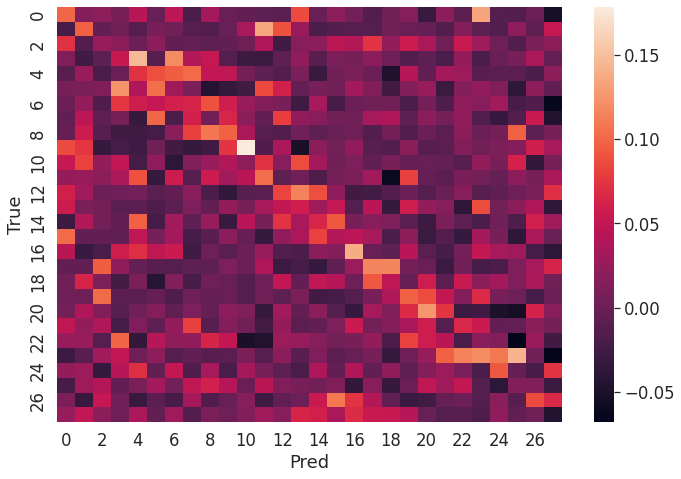

In [42]:
import seaborn as sns

adj = model.adj.cpu().detach().numpy()
plt.figure(figsize=(10, 7))
sns.set(font_scale=1.5)
sns.heatmap(adj, fmt='g')
plt.ylabel('True')
plt.xlabel('Pred')
plt.tight_layout()
plt.savefig('images/autogcn_mnist_adj.png')
plt.show()

In [60]:
def adj2edgelist(adj):
    edge_list = []
    for u in range(len(adj)):
        for v in range(len(adj)):
            if adj[u, v] == 0:
                continue
            elif adj[u, v] < 0:
                edge_list.append([u, v, 'r', adj[u, v]])
            else:
                edge_list.append([u, v, 'b', adj[u, v]])
    return edge_list

def plot_adj_as_graph(adj_mat, threshold, show_edge_labels):
    np.fill_diagonal(adj_mat, 0)
    adj_mat = np.where(abs(adj_mat) > threshold, adj_mat, 0)
    adj_mat = np.round(adj_mat, 2)
    edge_list = adj2edgelist(adj_mat)

    G = nx.DiGraph()
    for (u, v, color, weight) in edge_list:
        G.add_edge(u, v, color=color, weight=weight)

    edges = G.edges()
    colors = [G[u][v]['color'] for u,v in edges]
    weights = [G[u][v]['weight']*20 for u,v in edges]
    # pos = nx.circular_layout(G)
    pos = nx.spring_layout(G, k=0.3)
    edge_labels = nx.get_edge_attributes(G,'weight')

    plt.figure(figsize=(10, 10))
    
    nx.draw(G, pos=pos, with_labels=True, node_size=800, edge_color=colors, width=weights)
    if show_edge_labels:
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
    plt.title(f'Threshold: {threshold}')
    plt.savefig('./images/autogcn_ec1_mnist.png')
    plt.show()
    return G

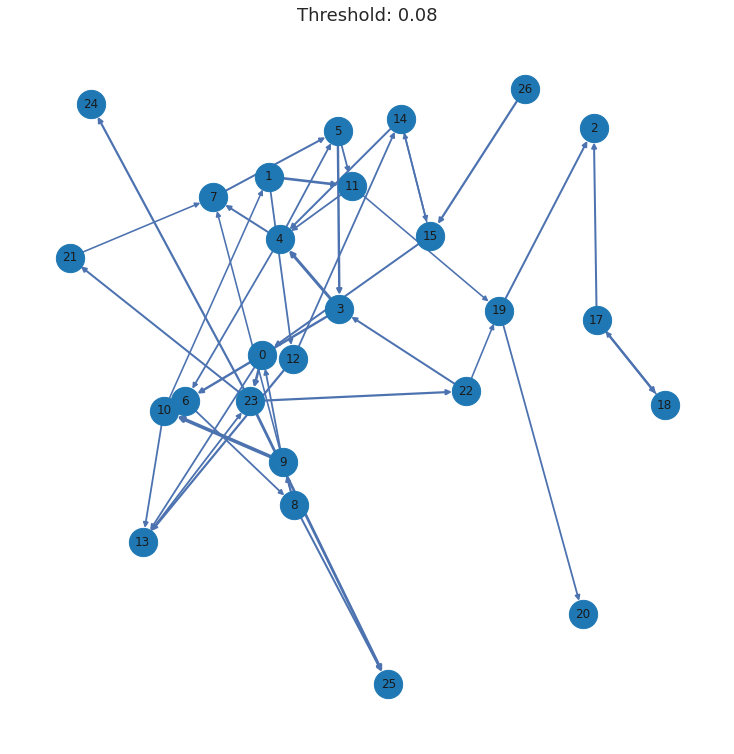

In [61]:
G = plot_adj_as_graph(adj, 0.08, show_edge_labels=False)